In [13]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
# imports
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.io as io
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [33]:
# gpu details
gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(gpu)

cpu = torch.device('cpu')
print(cpu)

cuda_id = torch.cuda.current_device()
print('ID of current CUDA device: {}'.format(torch.cuda.current_device()))     
print('Name of current CUDA device: {}'.format(torch.cuda.get_device_name(cuda_id)))

cuda
cpu
ID of current CUDA device: 0
Name of current CUDA device: Tesla K80


In [4]:
# directory paths
cur_dir = os.getcwd()
load_dataset_dir = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(cur_dir, 'drive'), 'MyDrive'), 'Coursework'), 'Current Semester'), 'ECSE 552'), 'ECSE 552 Project'), 'load_dataset')
# load_dataset_dir = os.path.join(os.path.join(os.path.join(os.path.join(cur_dir, 'drive'), 'MyDrive'), 'ECSE 552 Project'), 'load_dataset')
dataset_dir = os.path.join(load_dataset_dir, 'dataset')
train_set_dir = os.path.join(dataset_dir, 'train')
test_set_dir = os.path.join(dataset_dir, 'test')

In [5]:
# dataframes holding the label image label info
train_frame = pd.read_csv(os.path.join(dataset_dir, 'train_labels.csv'))
test_frame = pd.read_csv(os.path.join(dataset_dir, 'test_labels.csv'))

In [6]:
# extract filenames and labels into arrays
train_img_names = train_frame.iloc[0:, 0]
train_labels = np.asarray(train_frame.iloc[0:, 1])

test_img_names = test_frame.iloc[0:, 0]
test_labels = np.asarray(test_frame.iloc[0:, 1])

healthy: 18468, diseased: 41875


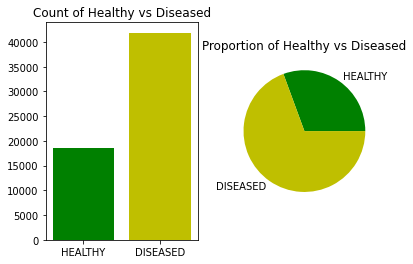

In [7]:
# visualize the number of healthy vs number of diseased samples in train set
num_healthy = sum(train_labels)
num_diseased = len(train_labels) - num_healthy
print('healthy: {}, diseased: {}'.format(num_healthy, num_diseased))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.bar(['HEALTHY', 'DISEASED'], [num_healthy, num_diseased], color=['g', 'y'])
ax1.set_title('Count of Healthy vs Diseased')

ax2.pie([num_healthy, num_diseased], labels=['HEALTHY', 'DISEASED'], colors=['g', 'y'])
ax2.set_title('Proportion of Healthy vs Diseased')

plt.show()

healthy: 3496, diseased: 3159


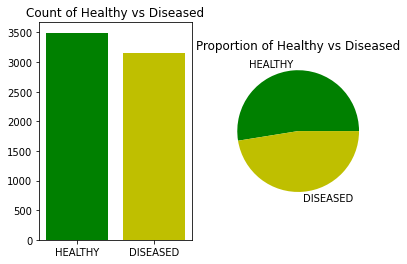

In [8]:
# same as above, but for test set
num_healthy = sum(test_labels)
num_diseased = len(test_labels) - num_healthy
print('healthy: {}, diseased: {}'.format(num_healthy, num_diseased))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.bar(['HEALTHY', 'DISEASED'], [num_healthy, num_diseased], color=['g', 'y'])
ax1.set_title('Count of Healthy vs Diseased')

ax2.pie([num_healthy, num_diseased], labels=['HEALTHY', 'DISEASED'], colors=['g', 'y'])
ax2.set_title('Proportion of Healthy vs Diseased')

plt.show()

In [9]:
def show_image(image, label):
  """Show image with label"""
  plt.imshow(image.permute(1,2,0)) # reshape to have channels in last dimension to satisfy plt
  plt.title('label={}'.format(label))

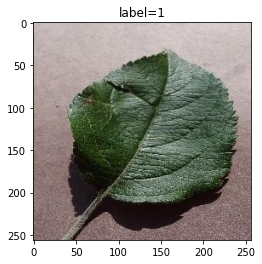

In [14]:
plt.figure()
show_image(io.read_image(os.path.join(train_set_dir, train_img_names[0]), mode=io.ImageReadMode.RGB), train_labels[0])
plt.show()

In [15]:
class LeafDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
          csv_file (string): Path to the csv file with annotations.
          root_dir (string): Directory with all the images.
          transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.label_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.label_frame)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.label_frame.iloc[idx, 0])
        img = io.read_image(img_name, mode=io.ImageReadMode.RGB)
        label = torch.tensor([self.label_frame.iloc[idx, 1]])

        if self.transform:
          img = self.transform(img)

        return img, label

0 torch.Size([3, 256, 256]) tensor([1])
1 torch.Size([3, 256, 256]) tensor([1])
2 torch.Size([3, 256, 256]) tensor([1])
3 torch.Size([3, 256, 256]) tensor([1])


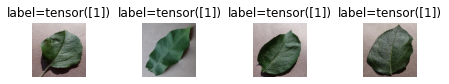

In [16]:
# construct training set
train_dataset = LeafDataset(csv_file=os.path.join(dataset_dir, 'train_labels.csv'), root_dir=train_set_dir)

# display first 4 samples from train set
fig = plt.figure()
for i in range(len(train_dataset)):
  # sample = train_dataset[i]
  img, label = train_dataset[i]

  # print(i, sample['image'].shape, sample['label'])
  print(i, img.shape, label)

  ax = plt.subplot(1, 4, i+1)
  plt.tight_layout()
  ax.set_title('Sample #{}'.format(i))
  ax.axis('off')
  # show_image(**sample)
  show_image(img, label)

  if i == 3:
    plt.show()
    break

In [39]:
# sample datasets for testing purposes
train_set, val_set=torch.utils.data.random_split(train_dataset, [10000,50343])
sample_train_set, sample_val_set=torch.utils.data.random_split(train_set, [8000,2000])

sample_dataloader = DataLoader(sample_val_set, batch_size=256, shuffle=True, num_workers=2)

In [40]:
for i, sample in enumerate(sample_dataloader):
  img, label = sample
  print(i, img.shape, label.shape)

0 torch.Size([256, 3, 256, 256]) torch.Size([256, 1])
1 torch.Size([256, 3, 256, 256]) torch.Size([256, 1])
2 torch.Size([256, 3, 256, 256]) torch.Size([256, 1])
3 torch.Size([256, 3, 256, 256]) torch.Size([256, 1])
4 torch.Size([256, 3, 256, 256]) torch.Size([256, 1])
5 torch.Size([256, 3, 256, 256]) torch.Size([256, 1])
6 torch.Size([256, 3, 256, 256]) torch.Size([256, 1])
7 torch.Size([208, 3, 256, 256]) torch.Size([208, 1])


# Twin Matching NN
## Key idea:
- Train matching NN to detect whether two input images have the same binary class (healthy vs diseased) or not.
- To classify an unkown image, run it through the trained NN with a known image (or possibly one of each class, maybe more) to see if the NN says it is the same class as the known image.

## Steps:
1. Training stage
  1. Create two DataLoaders from the same training set.
  2. For every epoch:
    1. For every sample of two images (one from each DataLoader):
      1. Set y as y1 == y2 (i.e., are the two images of the same class?)
      2. Feed both images into model to obtain result, y_hat
      3. Use y and y_hat to calculate loss, via loss function
      4. Backprop loss
      5. Step optimizer



In [149]:
# creating matching neural networks
class MatchingNetwork(nn.Module):
  def __init__(self, input_size):
    super(MatchingNetwork, self).__init__()
    
    # conv -> (6, 252, 252)
    # pool -> (6, 84, 84)
    self.layer1 = torch.nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
      nn.MaxPool2d(kernel_size=3, stride=3),
      nn.ReLU())
    
    # conv -> (12, 80, 80)
    # pool -> (12, 40, 40)
    self.layer2 = torch.nn.Sequential(
      nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.ReLU())
    
    # conv -> (24, 38, 38)
    # pool -> (24, 19, 19)
    self.layer3 = torch.nn.Sequential(
      nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.ReLU())
    
    # fcl -> (1, 64)
    self.layer4 = torch.nn.Sequential(
      nn.Linear(24 * 19 * 19, 64),
      nn.ReLU())
    
    # fcl -> (1, 32)
    self.layer5 = torch.nn.Sequential(
      nn.Linear(64, 32),
      nn.ReLU())
    
    # # fcl -> (1, 32)
    # self.layer6 = torch.nn.Sequential(
    #   nn.Linear(64, 32),
    #   nn.ReLU())

    # fcl -> (1, 1)
    self.out = nn.Linear(64, 1)
    
  def forward(self, x1, x2):
    x1 = self.layer1(x1)
    x1 = self.layer2(x1)
    x1 = self.layer3(x1)
    x1 = x1.view(-1, 24 * 19 * 19)
    x1 = self.layer4(x1)
    x1 = self.layer5(x1)
    # x1 = self.layer6(x1)

    x2 = self.layer1(x2)
    x2 = self.layer2(x2)
    x2 = self.layer3(x2)
    x2 = x2.view(-1, 24 * 19 * 19)
    x2 = self.layer4(x2)
    x2 = self.layer5(x2)
    # x2 = self.layer6(x2)

    return self.out(torch.cat([x1,x2], -1))

In [152]:
# actual dataloaders for the twin network (sample train set for dev purposes)
train_dl_1 = torch.utils.data.DataLoader(sample_train_set, batch_size=128, shuffle=True)
train_dl_2 = torch.utils.data.DataLoader(sample_train_set, batch_size=128, shuffle=True)

val_dl_1 = torch.utils.data.DataLoader(sample_val_set, batch_size=128, shuffle=True)
val_dl_2 = torch.utils.data.DataLoader(sample_val_set, batch_size=128, shuffle=True)

In [125]:
# performance metrics over the epochs
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

# training loop
def train(model, train_dl_1, train_dl_2, val_dl_1, val_dl_2, n_epoch, loss_func, optimizer):

  # train for n epochs
  for i in range(1, n_epoch+1):
    model.train()

    # init train metrics
    train_loss = 0
    train_accuracy = 0

    # iterate through each batch of both DataLoaders
    for batch_idx, (data1, data2) in enumerate(zip(train_dl_1, train_dl_2)): 
      x1 = data1[0].to(gpu).float() # image
      y1 = data1[1].to(gpu) # label
  
      x2 = data2[0].to(gpu).float() # image
      y2 = data2[1].to(gpu) # label
                  
      # set y to be whether both images are of same class
      y = ((y1 == y2)*1.0).view(-1,1)
      y = torch.squeeze(y,1)

      # reset the gradients
      optimizer.zero_grad() 
  
      # flatten the images before feeding into model for output
      y_hat = (model(x1, x2)).view(-1,1)
      y_hat = torch.squeeze(y_hat, 1)

      # calculate batch loss and update weights
      batch_loss = loss_func(y_hat, y)
      # print('epoch {}, batch {}, train loss {}'.format(i, batch_idx, batch_loss))
      batch_loss.backward() 
      optimizer.step() # weight update

      # accumulate metrics for this batch; will average after all batches complete
      train_loss += batch_loss.detach().cpu().numpy()
      train_accuracy += ((torch.sigmoid(y_hat) > 0.5)*1 == y).detach().cpu().numpy().mean()

    # average now that all batches complete
    train_loss = train_loss/(len(train_dl_1) + len(train_dl_2))
    train_accuracy = train_accuracy/(len(train_dl_1) + len(train_dl_2))

    # store metrics
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # evaluate
    model.eval()

    # init val metrics
    val_loss = 0
    val_accuracy = 0

    with torch.no_grad():
      for batch_idx, (data1, data2) in enumerate(zip(val_dl_1, val_dl_2)):
        x1 = data1[0].to(gpu).float() # image
        y1 = data1[1].to(gpu) # label
  
        x2 = data2[0].to(gpu).float() # image
        y2 = data2[1].to(gpu) # label

        # set y to be whether both images are of same class
        y = ((y1 == y2)*1.0).view(-1,1)
        y = torch.squeeze(y,1)

        # flatten the images before feeding into model for output
        y_hat = model(x1, x2).view(-1,1)
        y_hat = torch.squeeze(y_hat, 1)

        # calculate and print batch validation loss
        batch_loss = loss_func(y_hat, y)

        # accumulate metrics for this batch; will average after all batches complete
        val_loss += batch_loss.detach().cpu().numpy()
        val_accuracy += ((torch.sigmoid(y_hat) > 0.5)*1 == y).detach().cpu().numpy().mean()
        
        # print('epoch {}, batch {}, val loss {}'.format(i, batch_idx, batch_loss))

      # average now that all batches complete
      val_loss = val_loss/(len(val_dl_1) + len(val_dl_2))
      val_accuracy = val_accuracy/(len(val_dl_1) + len(val_dl_2))

      # store metrics
      val_accuracies.append(val_accuracy)
      val_losses.append(val_loss)

    print('epoch {}, train loss {}, train acc {}, val loss {}, val acc {}'.format(i, train_loss, train_accuracy, val_loss, val_accuracy))
            
  return model

In [153]:
# construct and train model
model = MatchingNetwork(256*256).cuda()
print('trainable params: ', sum(p.numel() for p in model.parameters() if p.requires_grad))
# summary(model, (3, 256, 256))

trainable params:  561589


In [155]:
bce = nn.BCEWithLogitsLoss()
bce_loss = lambda y_hat, y: bce(y_hat.view(-1,1),y.view(-1,1))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model = train(model, train_dl_1, train_dl_2, val_dl_1, val_dl_2, 50, bce, optimizer)

epoch 1, train loss 0.33983429462190656, train acc 0.28726438492063494, val loss 0.33894120529294014, val acc 0.293017578125
epoch 2, train loss 0.3409760561254289, train acc 0.2877604166666667, val loss 0.3391547482460737, val acc 0.290673828125
epoch 3, train loss 0.3400150300964477, train acc 0.28943452380952384, val loss 0.33808910474181175, val acc 0.29677734375
epoch 4, train loss 0.3389277557531993, train acc 0.2880704365079365, val loss 0.3395866584032774, val acc 0.28876953125
epoch 5, train loss 0.33745758117191377, train acc 0.2884424603174603, val loss 0.3397289738059044, val acc 0.279736328125
epoch 6, train loss 0.33027103306755184, train acc 0.30146329365079366, val loss 0.3283801209181547, val acc 0.296826171875
epoch 7, train loss 0.32152364556751556, train acc 0.31950644841269843, val loss 0.32179204747080803, val acc 0.33720703125
epoch 8, train loss 0.3138409928670005, train acc 0.32787698412698413, val loss 0.3097570315003395, val acc 0.335888671875
epoch 9, train 

In [ ]:
model = train(model, train_dl_1, train_dl_2, val_dl_1, val_dl_2, 100, bce, optimizer)

epoch 1, train loss 0.2805130488815762, train acc 0.4025297619047619, val loss 0.2859578812494874, val acc 0.38515625
epoch 2, train loss 0.2857556813766086, train acc 0.404265873015873, val loss 0.30419520661234856, val acc 0.3328125
epoch 3, train loss 0.2835878140869595, train acc 0.4037698412698413, val loss 0.29050381667912006, val acc 0.374072265625
epoch 4, train loss 0.2798689050333841, train acc 0.4068080357142857, val loss 0.28719253465533257, val acc 0.372607421875
